In [52]:
# Install required libraries (if not already installed)
!pip install yfinance networkx torch torch-geometric

[*********************100%***********************]  5 of 5 completed


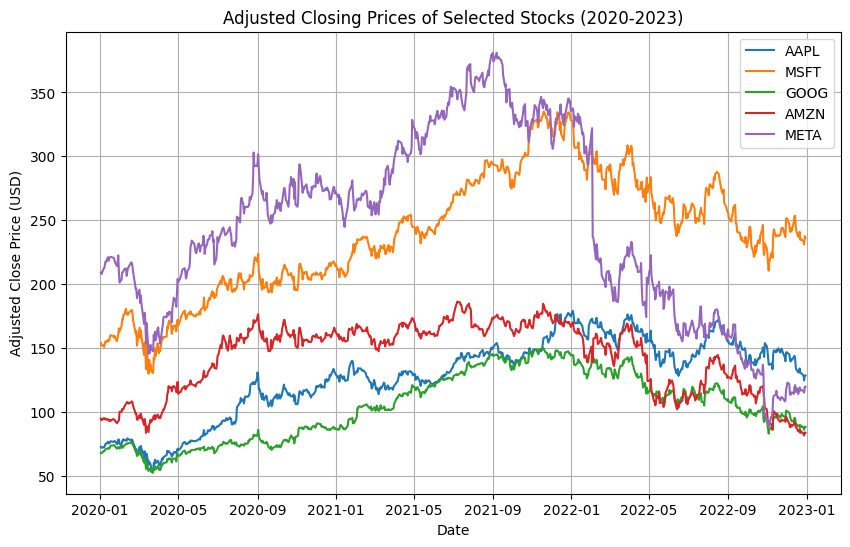

Enhanced Node Features Shape: torch.Size([5, 6])
First 5 Node Features (Identity + Volatility):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0233],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0246],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0217],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0307],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0219]], dtype=torch.float64)


In [53]:
import yfinance as yf
import matplotlib.pyplot as plt

# List of stock tickers (companies we're interested in)
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']

# Fetch historical stock prices for the tickers from 2020 to 2023
stock_data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns (percentage change in prices day by day)
daily_returns = stock_data.pct_change().dropna()

# Check for NaN values and drop them
stock_data = stock_data.dropna()

# Plot Adjusted Closing Prices
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(stock_data.index, stock_data[ticker], label=ticker)
plt.title("Adjusted Closing Prices of Selected Stocks (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Step 1: Calculate stock volatility (standard deviation of daily returns)
volatility = daily_returns.std().values  # Volatility for each company

# Create a mapping from node names (tickers) to numerical indices
import networkx as nx
node_mapping = {node: idx for idx, node in enumerate(tickers)}

# Enhanced node features: Identity matrix + Volatility (appending volatility as an additional feature)
import torch
node_features = torch.cat([torch.eye(len(tickers)), torch.tensor(volatility).unsqueeze(1)], dim=1)

# Verify the shape of the enhanced node features
print(f"Enhanced Node Features Shape: {node_features.shape}")
print("First 5 Node Features (Identity + Volatility):")
print(node_features[:5])


In [54]:
# Create correlation matrix
correlation_matrix = daily_returns.corr()

# Create adjacency matrix (edges formed based on correlation threshold)
threshold = 0.7
adjacency_matrix = (correlation_matrix > threshold).astype(int)

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes and edges to the graph
for stock in adjacency_matrix.columns:
    G.add_node(stock)

for i in range(len(adjacency_matrix.columns)):
    for j in range(i+1, len(adjacency_matrix.columns)):
        if adjacency_matrix.iloc[i, j] == 1:
            G.add_edge(adjacency_matrix.columns[i], adjacency_matrix.columns[j])

# Convert to PyTorch Geometric format
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges]).t().contiguous()

# Create data object for PyTorch Geometric
from torch_geometric.data import Data
data = Data(x=node_features, edge_index=edge_index)


In [55]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features.size(1), hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
    
    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
    def forward(self, x, edge_index):
        return self.encode(x, edge_index)


In [56]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(node_features.size(1), hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
    
    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
    def forward(self, x, edge_index):
        return self.encode(x, edge_index)


In [57]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(node_features.size(1), hidden_dim, heads=4)
        self.conv2 = GATConv(hidden_dim*4, hidden_dim, heads=1)  # Combine heads
    
    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
    def forward(self, x, edge_index):
        return self.encode(x, edge_index)


In [58]:
!pip install optuna

In [59]:
from sklearn.metrics import roc_auc_score

def predict_links(data, model):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)  # Get node embeddings
    
    # Compute similarity between node embeddings (dot product)
    link_logits = torch.mm(z, z.t())
    return link_logits

# Predict links (similarities between nodes)
link_predictions = predict_links(data, model)

# Example output: predicted similarities between companies
print("Predicted Link Similarities (closer means more likely to form a relationship):")
print(link_predictions)


NameError: name 'model' is not defined

In [8]:
from sklearn.metrics import roc_auc_score

# Function to predict link similarities
def predict_links(data, model):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)
    link_logits = torch.mm(z, z.t())
    return link_logits

# Evaluation function using AUC-ROC
def evaluate_model(model, data):
    link_predictions = predict_links(data, model)

    adj_matrix = torch.zeros((len(G.nodes), len(G.nodes)))
    for u, v in G.edges:
        adj_matrix[node_mapping[u], node_mapping[v]] = 1
        adj_matrix[node_mapping[v], node_mapping[u]] = 1

    true_labels = adj_matrix.flatten().numpy()
    predicted_scores = link_predictions.flatten().detach().numpy()

    auc_score = roc_auc_score(true_labels, predicted_scores)
    return auc_score

# Evaluate each model and print AUC-ROC scores
for model_name, model in models.items():
    auc = evaluate_model(model, data)
    print(f"{model_name} AUC-ROC Score: {auc:.4f}")


GCN AUC-ROC Score: 0.6667
GraphSAGE AUC-ROC Score: 0.6667
GAT AUC-ROC Score: 0.6667


In [9]:
# Fetch additional financial data (e.g., P/E ratio, market cap)
additional_data = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    pe_ratio = stock.info.get('trailingPE', 0)  # Get P/E ratio, default to 0 if not available
    market_cap = stock.info.get('marketCap', 0)  # Get Market Cap, default to 0 if not available
    volume = stock.info.get('volume', 0)  # Get Daily Trading Volume, default to 0 if not available
    additional_data[ticker] = [pe_ratio, market_cap, volume]

# Convert to tensor format
additional_features = torch.tensor([additional_data[ticker] for ticker in tickers], dtype=torch.float32)

# Combine original node features (identity + volatility) with additional financial features
node_features = torch.cat([node_features, additional_features], dim=1)

# Verify the updated node feature size
print(f"Updated Node Features Shape: {node_features.shape}")


Updated Node Features Shape: torch.Size([5, 9])
